# Optimization
This notebook includes a visualization of the optimization step on a simple 2-dimensional spline.

## Setup
Run the following cells to set up the notebook

In [1]:
import sys
import json

import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import least_squares

sys.path.append("..")
from demo.utils.optimization_2d import pairwise_objective_2d, reconstruct_transformation_2d
from demo.utils.visualizers import visualize_step_2d
from src.utils.transforms import apply_homogenous_transformation
sys.path.pop()

'..'

In [2]:
with open("../demo/duck.json", "r") as f:
    scans_dict = json.load(f)

In [3]:
original_shape = scans_dict['original_surface']
spline1 = np.array(scans_dict["scan_1"]["surface"])
points1 = np.array(scans_dict["scan_1"]["points"])
spline2 = np.array(scans_dict["scan_2"]["surface"])
points2 = np.array(scans_dict["scan_2"]["points"])

## Original Shape
The example shown in this notebook is the optimization step on a hand-picked matching points taken from a polygon (2d-spline) of a duck.

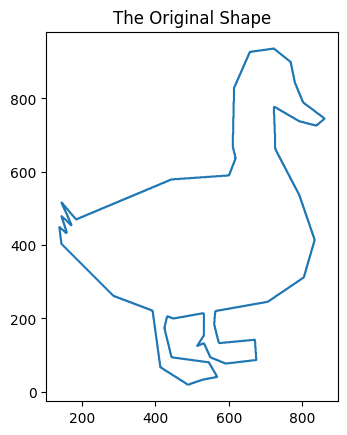

In [4]:
plt.figure()
plt.plot(*zip(*original_shape))
plt.gca().set_aspect("equal")
plt.title("The Original Shape")
plt.show()

## Normalization
To normalize the points we center them to the origin and scale them to have maximum distance of 1.
Since both sets of points were taken from the same object (and the returned transformation is rigid) we need to scale both sets of points by the same factor - the maximum distance of the first set of points.

In [5]:
points1_mean = points1.mean(axis=0)
points2_mean = points2.mean(axis=0)
points1_scale = np.linalg.norm(points1 - points1_mean, axis=1).max()
points1 = (points1 - points1_mean) / points1_scale
spline1 = (spline1 - points1_mean) / points1_scale
points2 = (points2 - points2_mean) / points1_scale
spline2 = (spline2 - points2_mean) / points1_scale

## Initial state
The following plot shows the initial state of the points.

The initial state was created by sampling points from two overlapping sections of the original polygon and matching them by hand (with intended noise), after that the second spline and its points were transformed by a random rigid transformation.

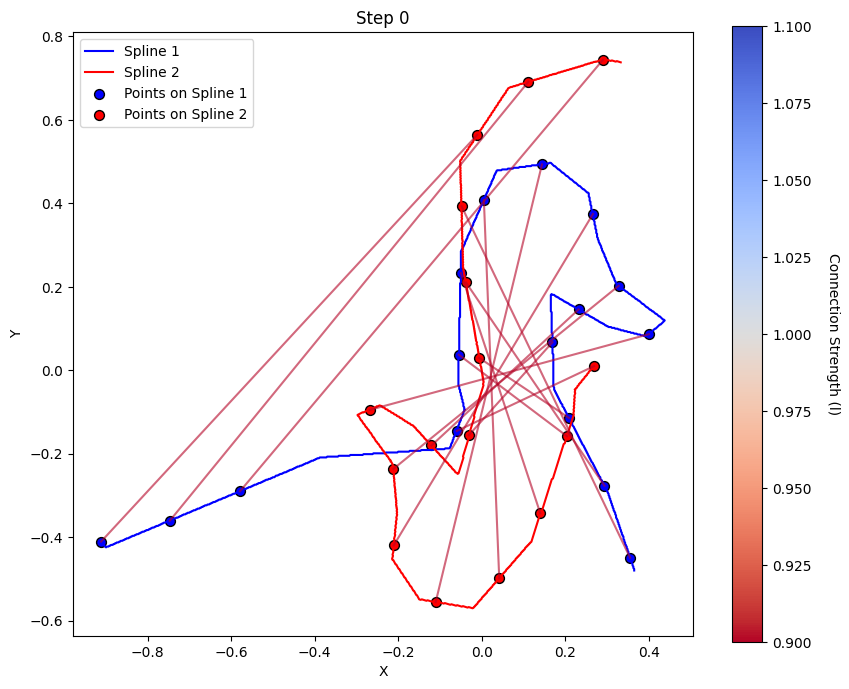

In [6]:
visualize_step_2d(spline1, spline2, points1, points2, np.ones(len(points1)), 0)

## Optimization Step
Fast-Global-registration optimizes the following global objective:
$$E(\mathbf{T}, \mathbf{L}) = \sum_{(p,q) \in \mathcal{K}} l_{p,q} \|\mathbf{p} - \mathbf{Tq}\|^2 + \sum_{(p,q) \in \mathcal{K}} \mu \left( \sqrt{l_{p,q}} - 1 \right)^2
$$
Where $\mathbf{T}$ us the rigid transformation that aligns the points in $Q$ to the points in $P$ and $\mathbf{L}$ is the correspondence weights.

The optimization preformed iteratively by alternating two steps that optimize the global objective
- Optimizing $\mathbf{L}$ by a vanishing the partial derivatives, this yield a closed form solution -  $l_{p,q} = \left( \frac{\mu}{\mu + \|\mathbf{p} - \mathbf{Tq}\|^2} \right)^2$
- Optimizing the transformation by least squares, we used the already implemented Levenberg-Marquardt which is similar to Gauss-Newton method used in the paper but with added regularization for stability.

The following function is an adaptation of the original optimization_step as it is implemented in the code.

In [7]:
def optimization_step_2d(p: np.ndarray, q: np.ndarray, t_: np.ndarray, mu_: float) -> tuple[
    np.ndarray, np.ndarray, float]:
    """
    an adaptation of the function optimization_step for the visualization on 2-dimensional data

    Args:
        p (np.ndarray): the matching points from the first point cloud
        q (np.ndarray): the matching points from the second point cloud
        t_ (np.ndarray): the current value of the transformation matching the first point cloud to the second point cloud
        mu_ (float): the Geman-McClure scale (as described in section 3.1)

    Returns:
        t (np.ndarray): the updated transformation matrix calculated after the optimization step
    """
    # calculate the l weights according to the partial derivatives (formula 6)
    dists: np.ndarray = np.linalg.norm(p - apply_homogenous_transformation(points=q, transformation_matrix=t_), axis=1)
    l_: np.ndarray = (mu_ / (mu_ + dists ** 2)) ** 2

    # find the new transformation using Levenberg-Marquardt algorithm
    xi_0 = 0, 0, 0
    result = least_squares(pairwise_objective_2d, xi_0, args=(p, q, t_, l_), method='lm')

    t_new: np.ndarray = reconstruct_transformation_2d(t_, result.x)

    objective = pairwise_objective_2d(result.x, p, q, t_, l_).sum() + (mu_ * (np.sqrt(l_) - 1) ** 2).sum()

    return t_new, l_, objective

## Optimization Loop

In [8]:
t = np.identity(3)
mu = 1

In [9]:
transformations: list[np.ndarray] = []
l_weights: list[np.ndarray] = []
objective_values: list[float] = []

In [10]:
for i in range(25):
    t, l_new, objective_new = optimization_step_2d(points1, points2, t, mu)

    transformations.append(t)
    l_weights.append(l_new)
    objective_values.append(objective_new)
    
    if i % 4 == 3:  # every 4 iterations
        mu /= 2

## The Value of the Objective at Each Iteration

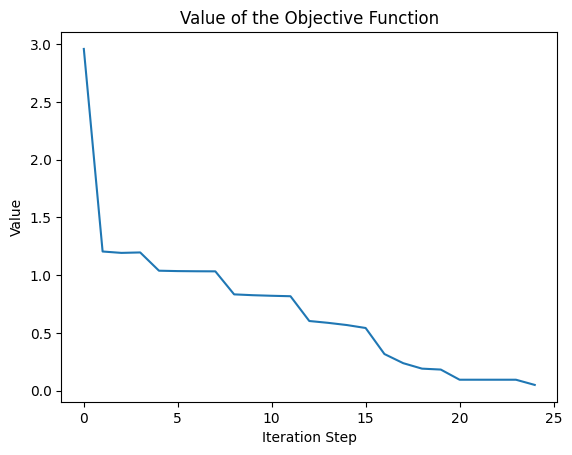

In [11]:
plt.plot(objective_values)
plt.title("Value of the Objective Function")
plt.xlabel("Iteration Step")
plt.ylabel("Value")
plt.show()

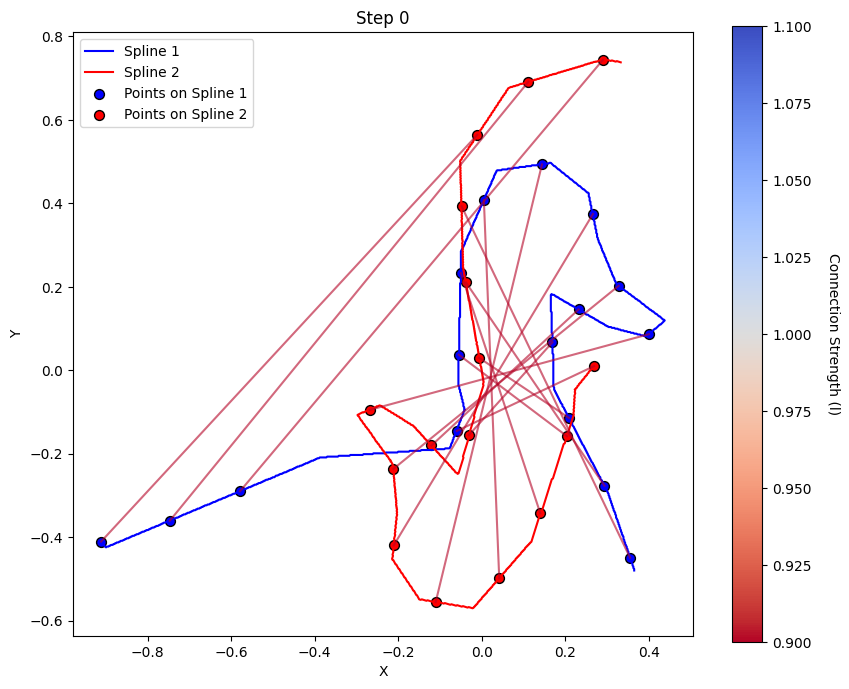

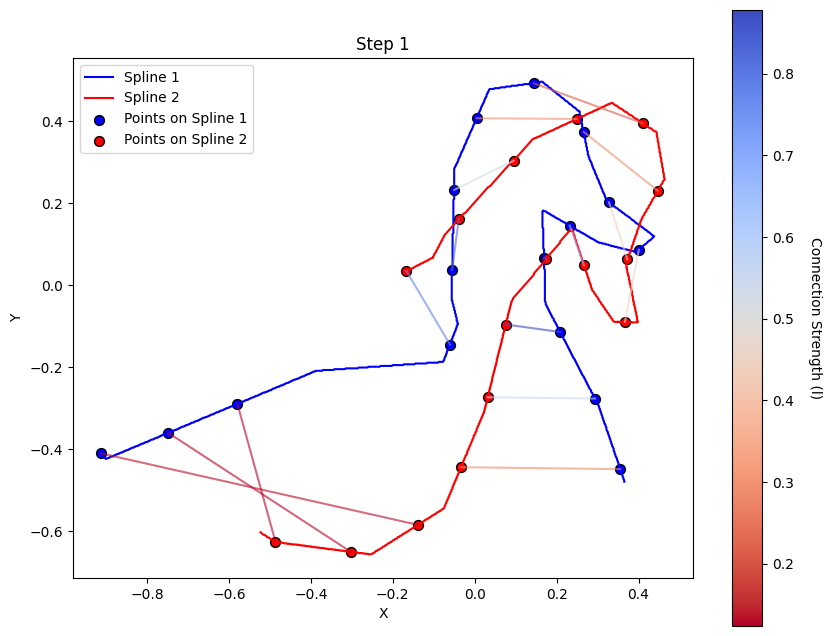

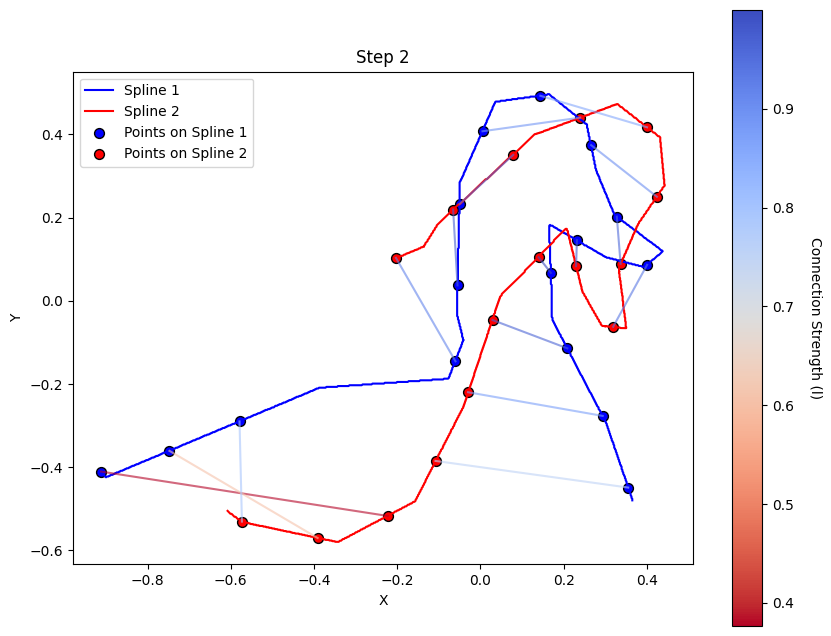

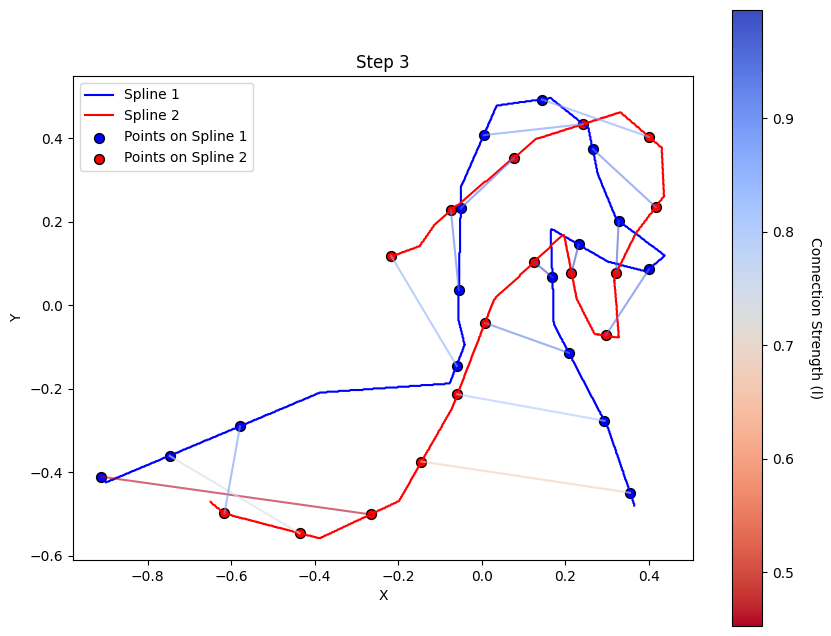

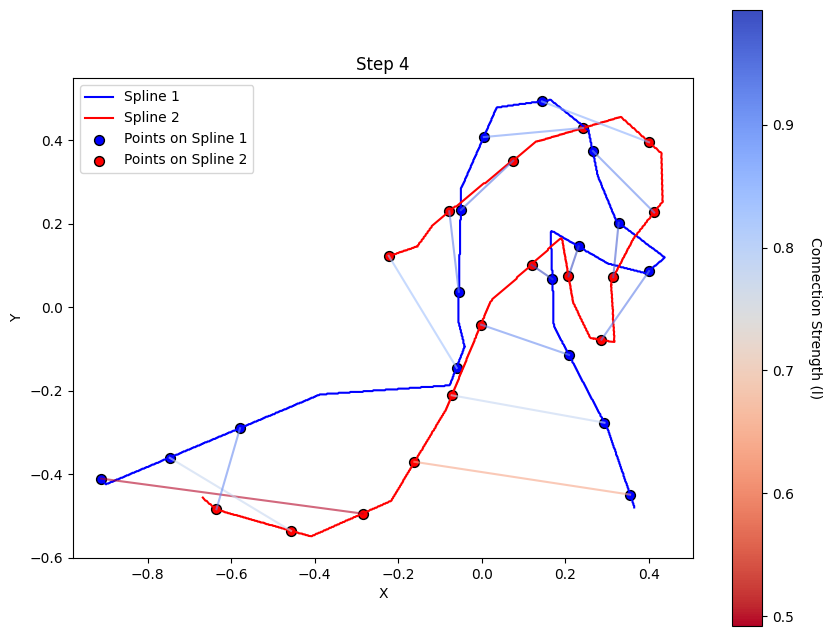

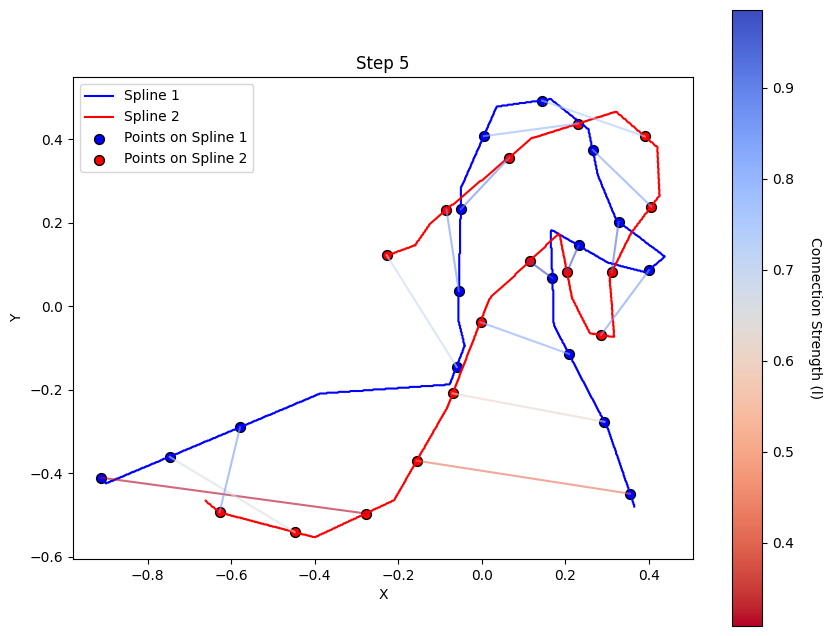

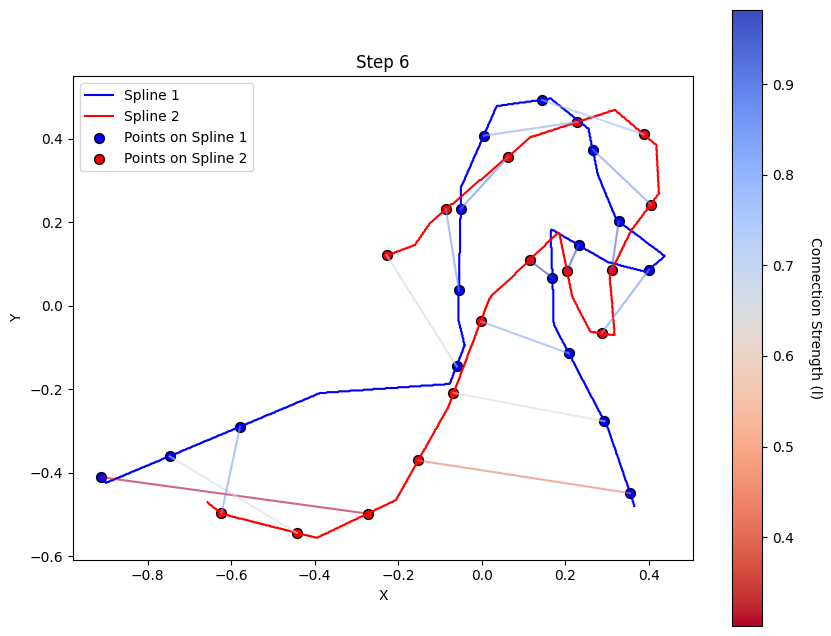

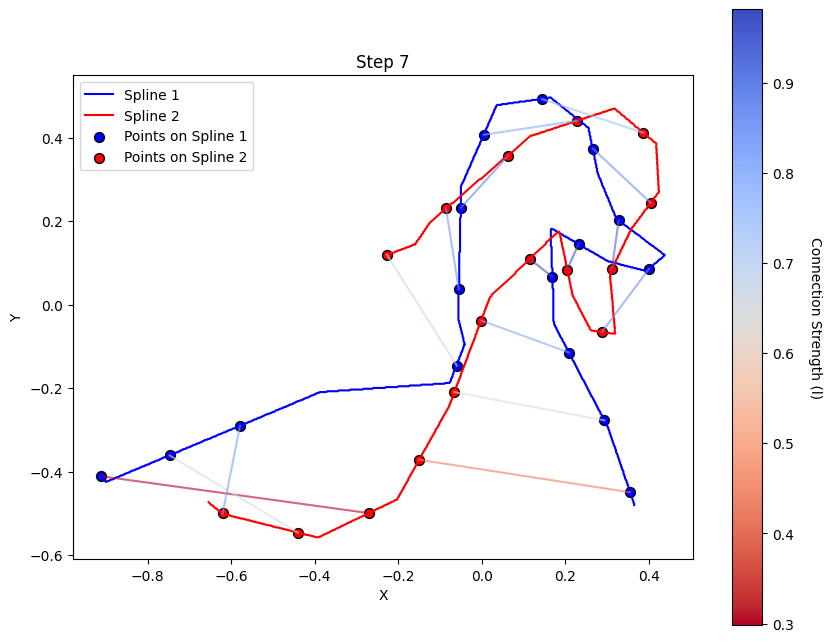

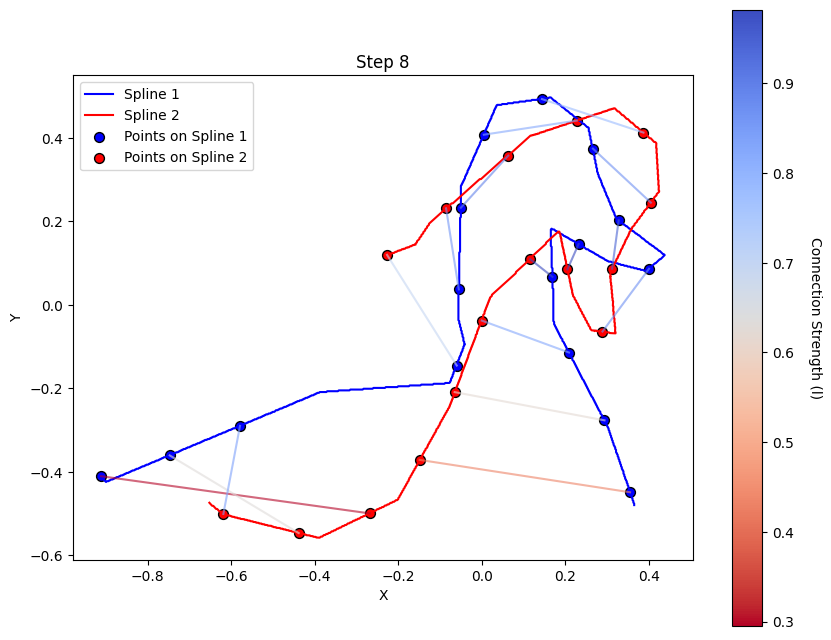

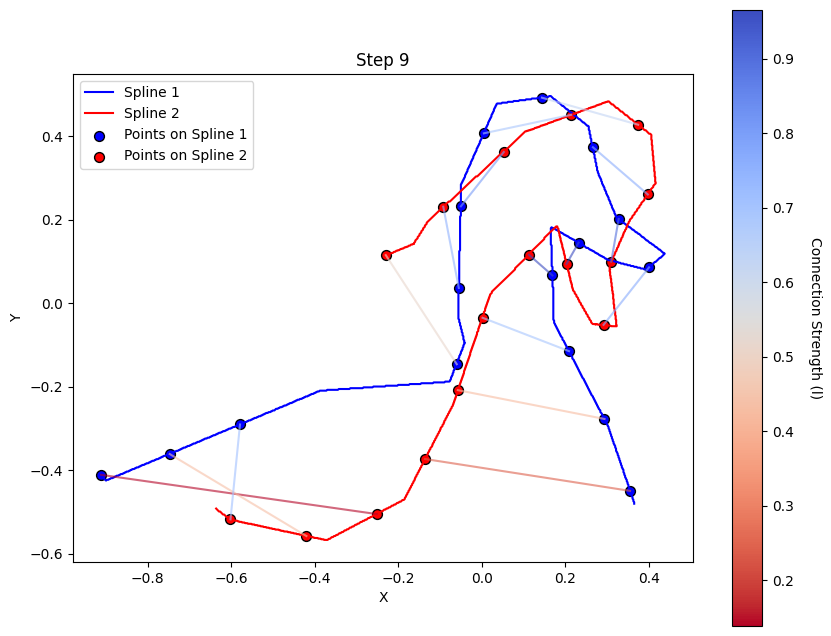

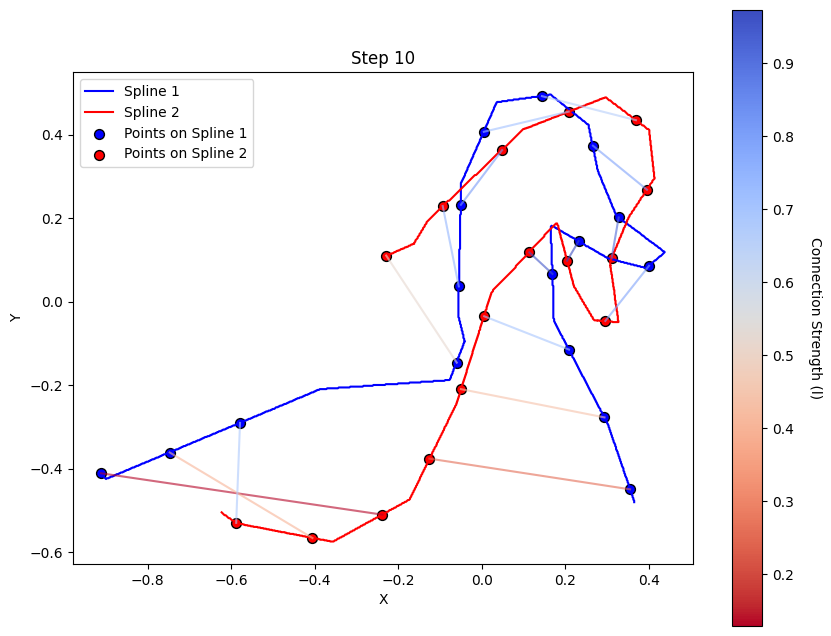

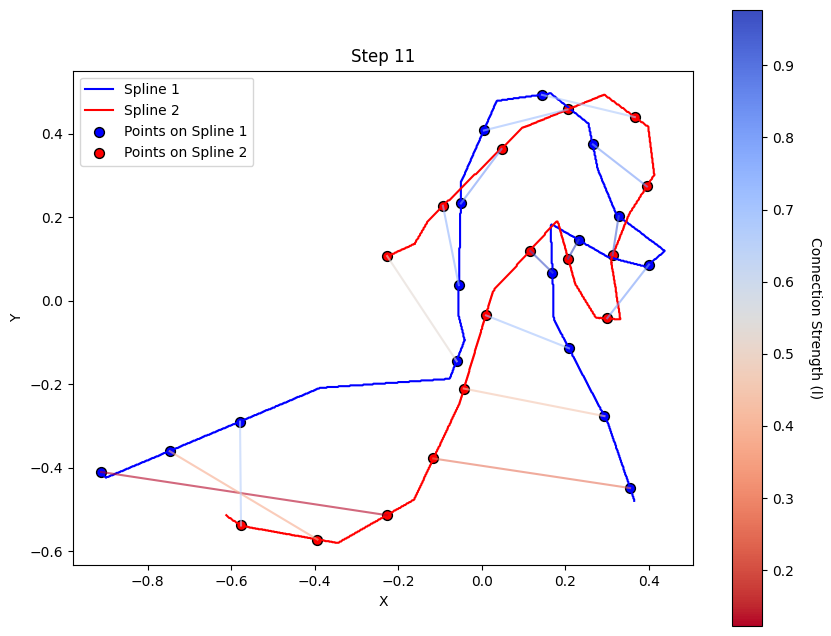

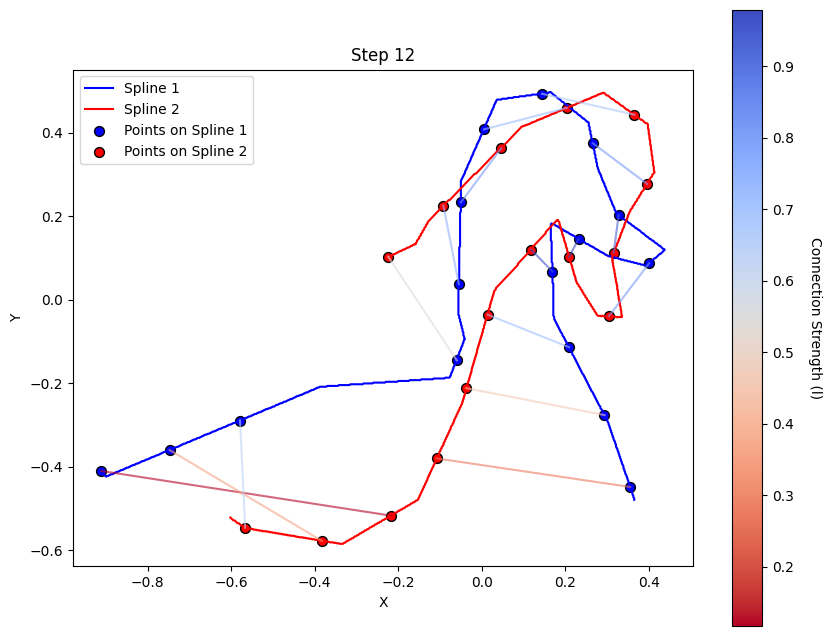

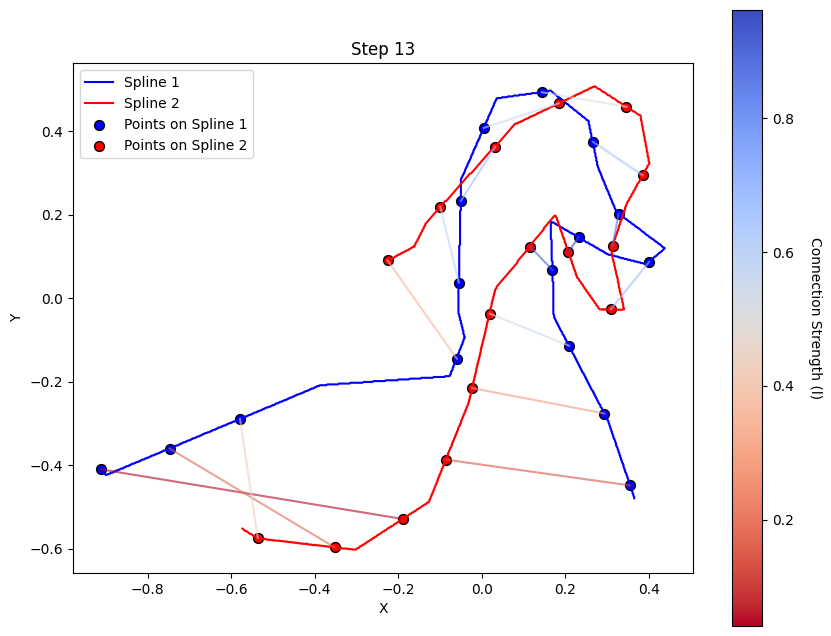

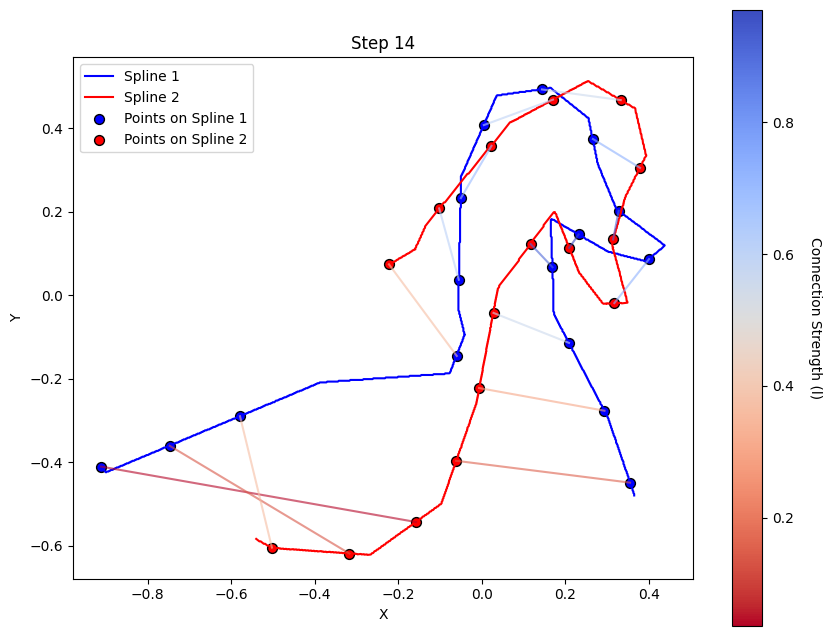

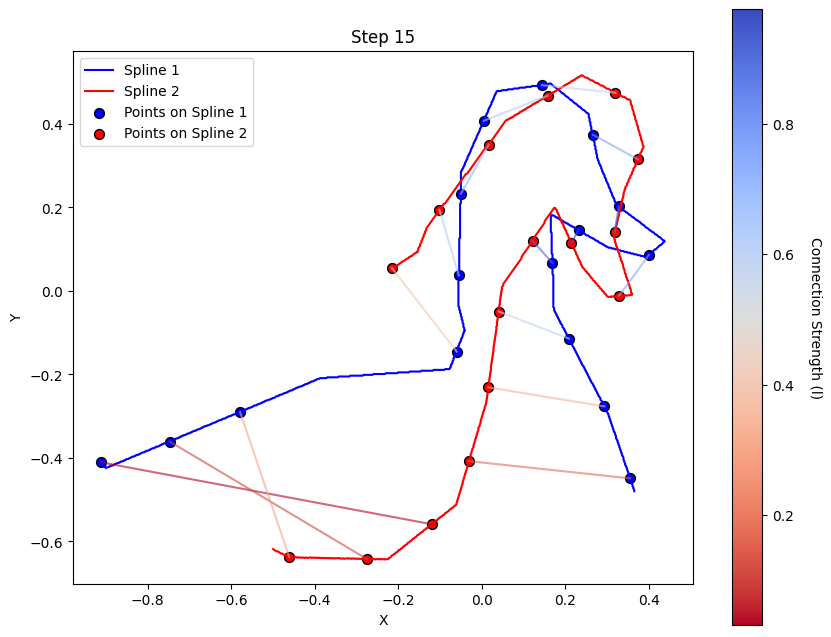

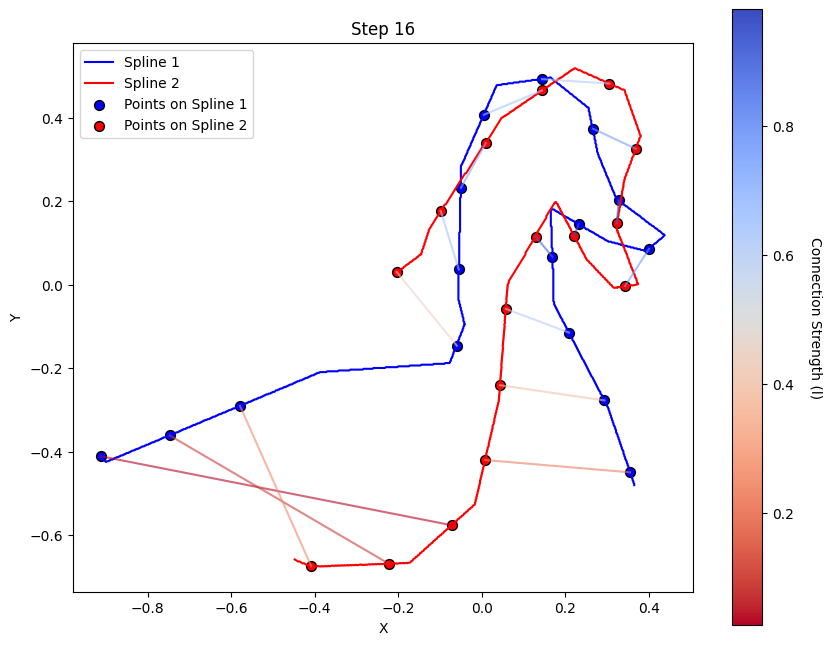

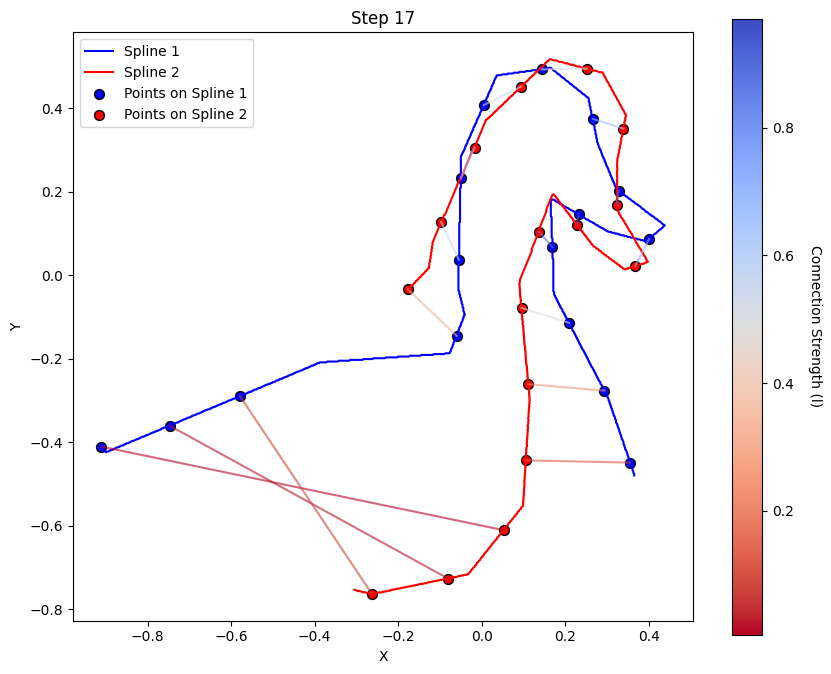

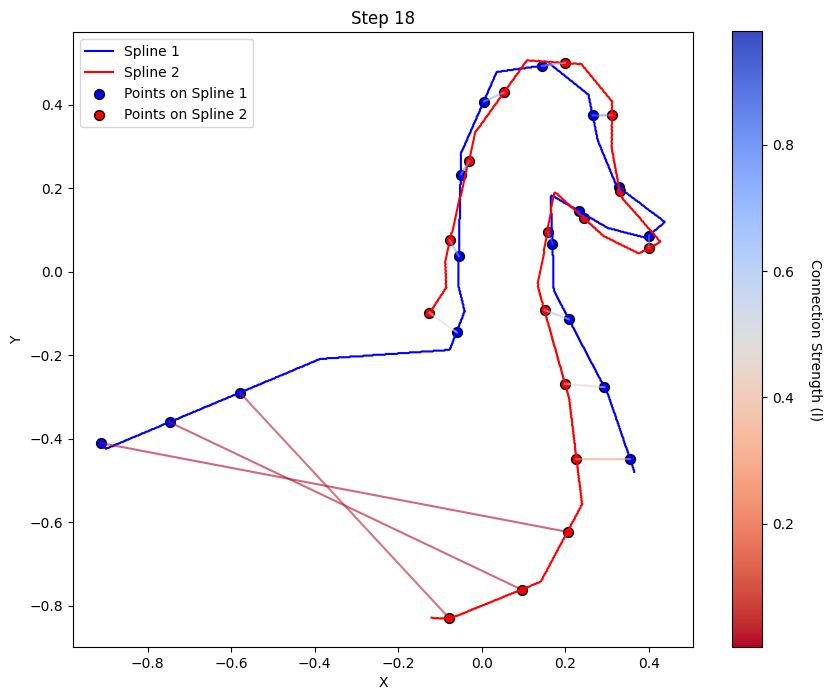

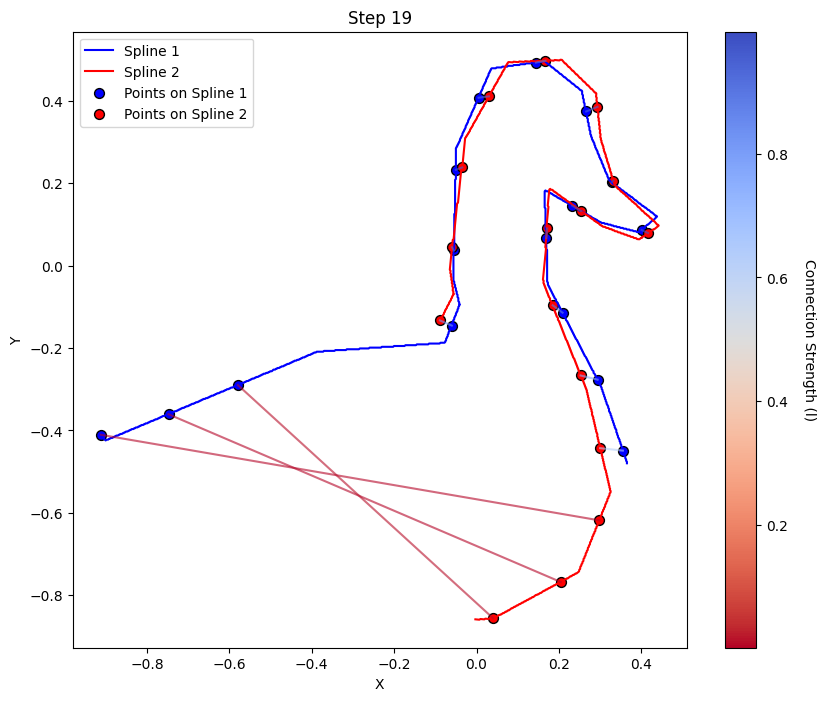

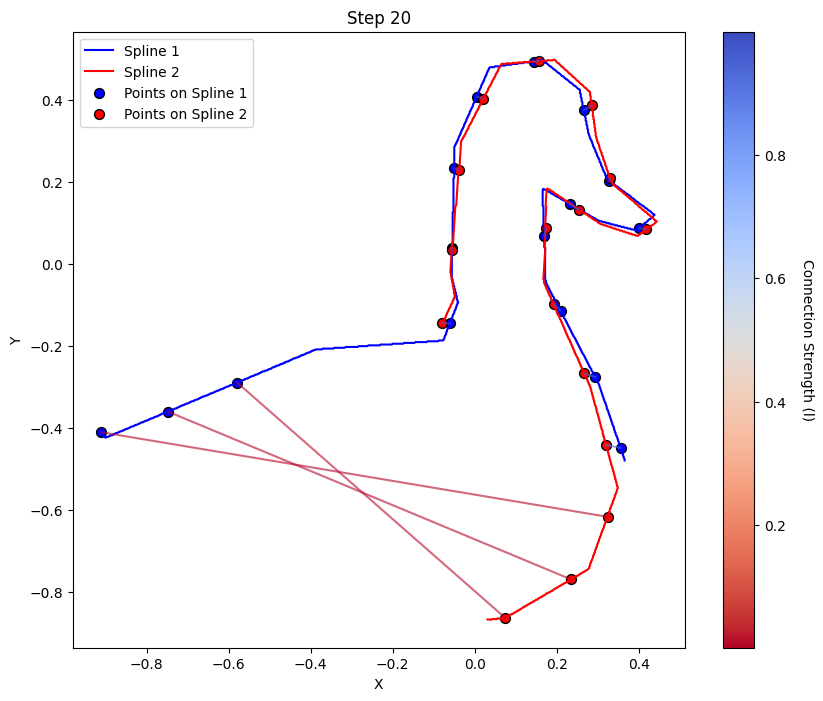

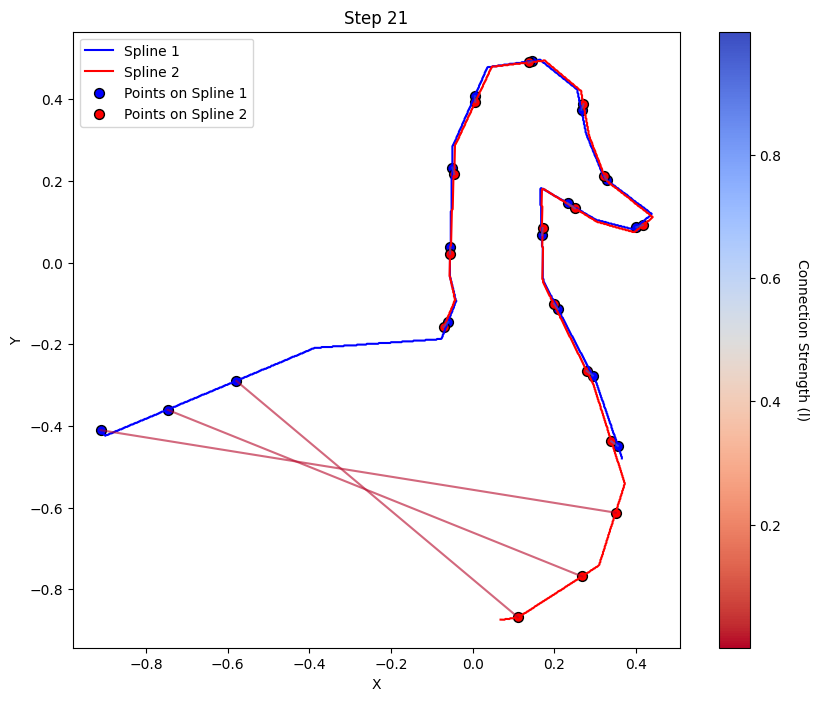

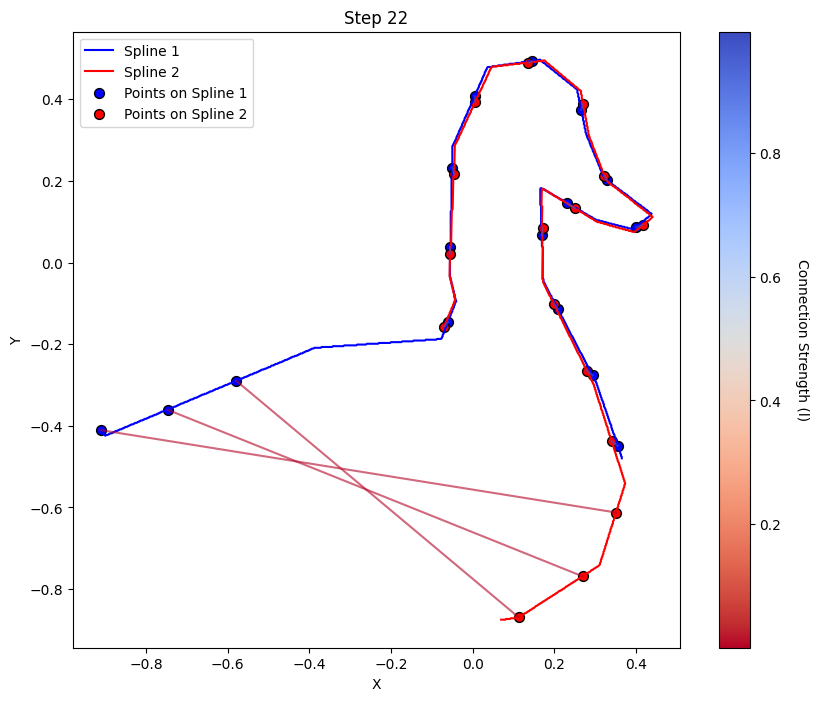

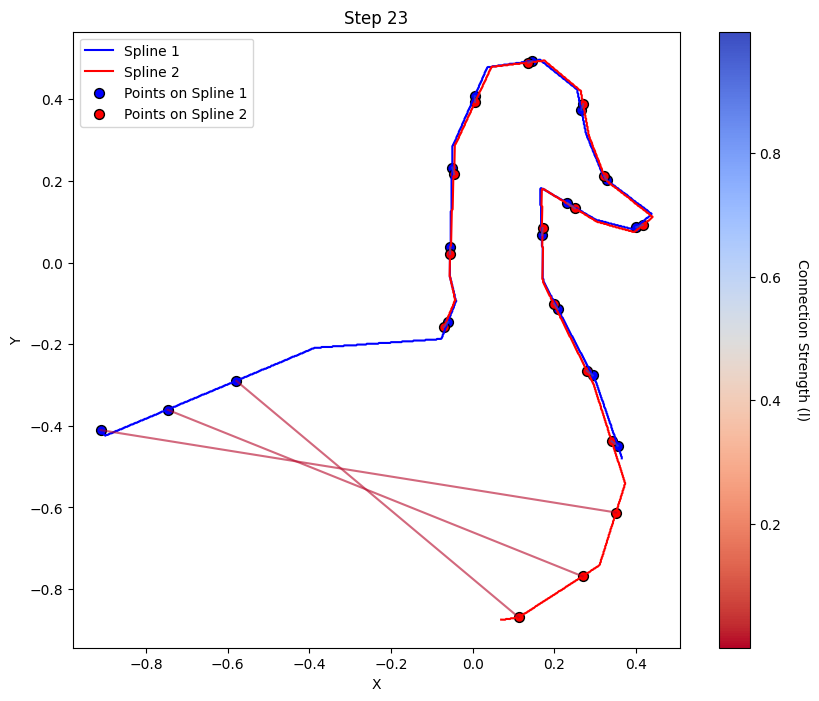

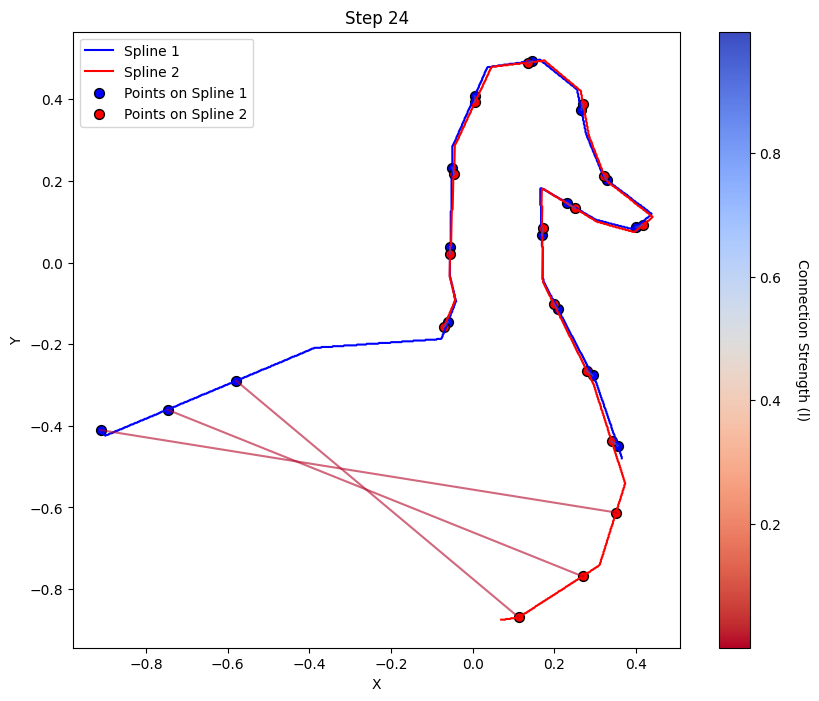

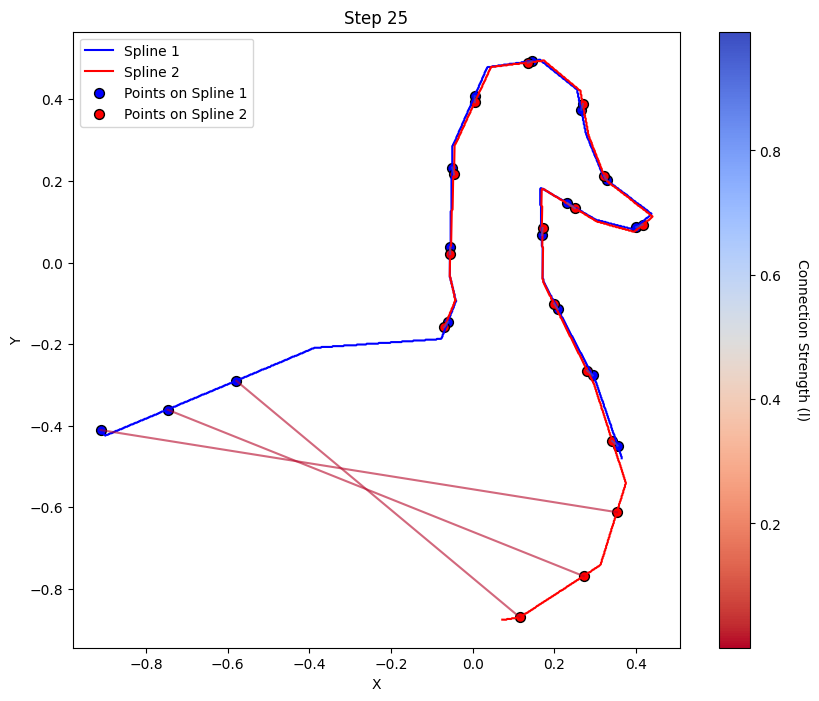

In [12]:
visualize_step_2d(spline1, spline2, points1, points2, np.ones(len(points1)), 0)
for i in range(25):
    transformed_spline2 = apply_homogenous_transformation(points=spline2, transformation_matrix=transformations[i])
    transformed_points2 = apply_homogenous_transformation(points=points2, transformation_matrix=transformations[i])
    visualize_step_2d(spline1, transformed_spline2, points1, transformed_points2, l_weights[i], i+1)